# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

#### Признаки
DateCrawled — дата скачивания анкеты из базы  
VehicleType — тип автомобильного кузова  
RegistrationYear — год регистрации автомобиля  
Gearbox — тип коробки передач  
Power — мощность (л. с.)  
Model — модель автомобиля  
Kilometer — пробег (км)  
RegistrationMonth — месяц регистрации автомобиля  
FuelType — тип топлива  
Brand — марка автомобиля  
NotRepaired — была машина в ремонте или нет  
DateCreated — дата создания анкеты  
NumberOfPictures — количество фотографий автомобиля  
PostalCode — почтовый индекс владельца анкеты (пользователя)  
LastSeen — дата последней активности пользователя  

#### Целевой признак  
Price — цена (евро)


#### Часть 1. [Подготовка данных](#part1)
* [1. Импорт библиотек.](#part1.1)
* [2. Загрузка и изучение данных](#part1.2)
* [3. Удаление признаков.](#part1.3)
* [4. Удаление объектов](#part1.4)
* [5. Заполнение пропусков.](#part1.5)
* [6. Кодирование признаков](#part1.6)
* [7. Масштабирование признаков](#part1.7)


#### Часть 2. [Обучение моделей](#part2)
* [2.1 Разбиение данных](#part2.1)
* [2.2 Dummy модель](#part2.2)
* [2.3 Решающее дерево](#part2.3)
* [2.4 Случайный лес](#part2.4)
* [2.5 Градиентный бустинг](#part2.5)

#### Часть 3. [Анализ моделей](#part3)

#### Часть 4. [Общий вывод](#part4)

<a id='part1'></a>
# 1. Подготовка данных
<a id='part1.1'></a>
## 1.1 Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.dummy import DummyRegressor

<a id='part1.2'></a>
## 1.2 Загрузка и изучение данных

In [2]:
data = pd.read_csv('/datasets/autos.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

Text(0.5, 0, 'Цена')

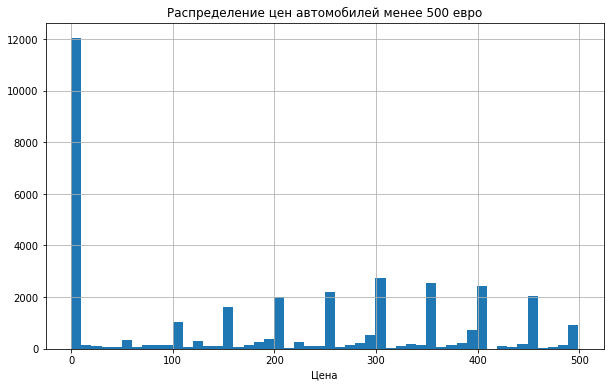

In [4]:
data['Price'][data['Price']<500].hist(bins=50, figsize=(10,6))
plt.title('Распределение цен автомобилей менее 500 евро')
plt.xlabel('Цена')

Присутствуют пропуски в признаках: VehicleType, Gearbox, Model, FuelType, NotRepaired. Все признаки с пропусками - категориальные.

В данных есть признаки, использование которых не поможет в определении цены:

* DateCrawled (дата скачивания анкеты из базы)
* DateCreated (дата создания анкеты)
* PostalCode (почтовый индекс владельца
* LastSeen (дата последней активности пользователя)
* NumberOfPictures (количество фотографий автомобиля)
* RegistrationMonth (в данных есть год регистрации, его достаточно)

Эти признаки можно удалить.

В столбце RegistrationYear присутствуют ошибки (года > 2020 и меньше 1930). Объекты с такими ошибками стоит удалить.

В значениях целевого признака для некторых объектов также присутствуют ошибки в виде слишком низкой или нулевой цены. Удалим автомобили с ценой меньше 99 евро.

<a id='part1.3'></a>
## 1.3 Удаление признаков

In [5]:
data = data.drop(columns = ['DateCrawled', 'DateCreated','PostalCode','LastSeen','NumberOfPictures','RegistrationMonth'],
                 axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
Price               354369 non-null int64
VehicleType         316879 non-null object
RegistrationYear    354369 non-null int64
Gearbox             334536 non-null object
Power               354369 non-null int64
Model               334664 non-null object
Kilometer           354369 non-null int64
FuelType            321474 non-null object
Brand               354369 non-null object
NotRepaired         283215 non-null object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


<a id='part1.4'></a>
## 1.4 Удаление объектов

Удалим автомобили со стоимостью меньше 100 евро и с годами регистрации до 1900 и после 2020 года.

In [6]:
data = data.query('Price > 98 & RegistrationYear > 1930 & RegistrationYear < 2020')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340997 entries, 0 to 354368
Data columns (total 10 columns):
Price               340997 non-null int64
VehicleType         308489 non-null object
RegistrationYear    340997 non-null int64
Gearbox             324762 non-null object
Power               340997 non-null int64
Model               324019 non-null object
Kilometer           340997 non-null int64
FuelType            312726 non-null object
Brand               340997 non-null object
NotRepaired         276712 non-null object
dtypes: int64(4), object(6)
memory usage: 28.6+ MB


<a id='part1.5'></a>
## 1.5 Заполнение пропусков

Заполним пропуски в категориальных признаках значением "Unknown".

In [7]:
data[['VehicleType', 'Model','Gearbox','FuelType','NotRepaired']] = \
data[['VehicleType', 'Model','Gearbox','FuelType','NotRepaired']].fillna('unknown')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340997 entries, 0 to 354368
Data columns (total 10 columns):
Price               340997 non-null int64
VehicleType         340997 non-null object
RegistrationYear    340997 non-null int64
Gearbox             340997 non-null object
Power               340997 non-null int64
Model               340997 non-null object
Kilometer           340997 non-null int64
FuelType            340997 non-null object
Brand               340997 non-null object
NotRepaired         340997 non-null object
dtypes: int64(4), object(6)
memory usage: 28.6+ MB


Для обучения простых моделей признаки необходимо подготовить: категориальные закодировать, а количественные масштабировать.

<a id='part1.6'></a>
## 1.6 Кодирование признаков

In [8]:
encoder = OrdinalEncoder()

data[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired','RegistrationYear']] \
= encoder.fit_transform(data[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired','RegistrationYear']])

data[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired','RegistrationYear']] = \
data[['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired','RegistrationYear']].astype(int)

data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,7,61,1,0,116,150000,6,38,1
1,18300,2,79,1,190,228,125000,2,1,2
2,9800,6,72,0,163,117,125000,2,14,1
3,1500,5,69,1,75,116,150000,6,38,0
4,3600,5,76,1,69,101,90000,2,31,0


<a id='part1.7'></a>
## 1.7 Масштабирование признаков

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345)


numeric = ['Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])
print(X_train.head())
print(X_test.head())

        VehicleType  RegistrationYear  Gearbox     Power  Model  Kilometer  \
327031            0                74        1 -0.033960    222   0.576616   
243473            0                63        1 -0.597304     93   0.576616   
94046             4                77        1 -0.114438    102  -1.037835   
26789             4                67        1 -0.597304    116   0.576616   
277499            7                63        1 -0.168090    166  -0.768760   

        FuelType  Brand  NotRepaired  
327031         2     38            0  
243473         2      9            2  
94046          2     10            0  
26789          6     38            0  
277499         7     35            2  
        VehicleType  RegistrationYear  Gearbox     Power  Model  Kilometer  \
53868             8                63        1 -0.114438    136   0.576616   
219647            5                72        1  0.277220     80   0.576616   
187180            8                79        1 -0.033960    116

## Вывод

Данные загружены и подготовлены. Удалены ненужные признаки и ошибки в данных, заполнены пропуски.   
Категориальные признаки закодированы, а количественные масштабированы.  

    

<a id='part2'></a>
# 2. Обучение моделей
<a id='part2.1'></a>
## 2.1 Разбиение данных

Разобьем данные на обучающую и тестовую выборки.

In [10]:
#Разбиение в п. 1.7
#X_train, X_test, y_train, y_test = train_test_split(
#    data.drop('Price', axis=1), data.Price, test_size=0.25, random_state=12345)

display(X_train.shape,X_test.shape)

(255747, 9)

(85250, 9)

<a id='part2.2'></a>
## 2.2 Dummy-модель

Для проверки адекватности моделей создадим Dummy модель, всегда предсказывающую медианное значение.

In [11]:
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train, y_train)
dummy_predicts = dummy_regr.predict(X_test)

print('RMSE Dummy-модели:')
print('{:.1f}'.format(mean_squared_error(dummy_predicts, y_test) ** 0.5))


RMSE Dummy-модели:
4848.6


<a id='part2.3'></a>
## 2.3 Дерево решений
Подберем оптимальные параметры модели с помощью RandomizedSearchCV

In [12]:
%%script false --no-raise-error
#пропуск выполнения ячейки


model_dt = DecisionTreeRegressor()

model_params = {
 
    'max_depth': [i for i in range(1,30)],
    'min_samples_split' : [i for i in range(2,30)],
    'min_samples_leaf' : [i for i in range(1,30)],
}

rs_dt = RandomizedSearchCV(model_dt, model_params, scoring='neg_root_mean_squared_error', n_jobs=-1, n_iter=200)
search_rs_dt = rs_dt.fit(X_train,y_train)
print('Лучшие гиперпараметры:')
print(search_rs_dt.best_estimator_)
print('Лучший RMSE:')
print(search_rs_dt.best_score_)

##### Вывод ячейки:
Лучшие гиперпараметры:  
DecisionTreeRegressor(max_depth=21, min_samples_leaf=5, min_samples_split=23)  

Лучший RMSE:  
-1835.5400020022796  

Обучим модель

In [13]:
%%time
model_dt = DecisionTreeRegressor(
 
    max_depth=21,
    min_samples_split=23,
    min_samples_leaf=5,
)
model_dt.fit(X_train, y_train)

CPU times: user 844 ms, sys: 190 µs, total: 844 ms
Wall time: 862 ms


DecisionTreeRegressor(criterion='mse', max_depth=21, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=23, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

<a id='part2.4'></a>
## 2.4 Случайный лес

Подберем оптимальные параметры модели с помощью RandomizedSearchCV

In [14]:
%%script false --no-raise-error
#пропуск выполнения ячейки

model_rf= RandomForestRegressor()

model_params = {
 
    'max_depth': [i for i in range(1,30)],
    'min_samples_split' : [i for i in range(2,30)],
    'min_samples_leaf' : [i for i in range(1,30)],
    'n_estimators' : [i for i in range(20,160,10)]
}

rs_rf = RandomizedSearchCV(model_rf, model_params, scoring='neg_root_mean_squared_error', n_jobs=-1, n_iter=200)

search_rs_rf = rs_rf.fit(X_train,y_train)
print('Лучшие гиперпараметры:')
print(search_rs_rf.best_estimator_)
print('Лучший RMSE:')
print(search_rs_rf.best_score_)

##### Вывод ячейки:
Лучшие гиперпараметры:  
RandomForestRegressor(max_depth=29, min_samples_leaf=4, min_samples_split=7,  
                      n_estimators=50)  

Лучший RMSE:  
-1658.4632138962165  

Обучим модель

In [15]:
%%time
model_rf = RandomForestRegressor(
 
    max_depth=29,
    min_samples_split=7,
    min_samples_leaf=4,
    n_estimators=50
)

model_rf.fit(X_train, y_train)

CPU times: user 31.9 s, sys: 109 ms, total: 32 s
Wall time: 32.1 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=29,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=7,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

<a id='part2.5'></a>
## 2.5 Градиентный бустинг

Определим оптимальные параметры градиентного бустинга с помощью RandomizedSearchCV.

In [16]:
%%script false --no-raise-error
#пропуск выполнения ячейки

model_gb = lgb.LGBMRegressor(silent=True)
                         
param_dist = {'num_leaves': [50,100,300,600],
             'max_depth' : [15,25,35,45,55,65],
             'learning_rate' : [0.01,0.05,0.1,0.3],
             'min_child_weight': [1e-1, 1, 1e1],
             'subsample': [0.6,0.7,0.8,0.9], 
             'colsample_bytree': [0.6,0.7,0.8],
             'reg_alpha': [0, 1e-1, 1, 5, 10, 50],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 50],
             'n_estimators' : [200]
             }

rs_gb = RandomizedSearchCV(
    estimator=model_gb, 
    param_distributions=param_dist, 
    scoring='neg_root_mean_squared_error',
    n_iter=200,
    cv=3,
    n_jobs=4
    )

search_rs_gb = rs_gb.fit(X_train,y_train)
print('Лучшие гиперпараметры:')
print(search_rs_gb.best_estimator_)
print('Лучший RMSE:')
print(search_rs_gb.best_score_)

##### Вывод ячейки:

Лучшие гиперпараметры:  
LGBMRegressor(colsample_bytree=0.7, max_depth=55, min_child_weight=10.0,  
              n_estimators=200, num_leaves=600, reg_alpha=5, reg_lambda=10,  
              subsample=0.7)  
              
Лучший RMSE:  
-1576.2724382810982  

Обучим модель

In [17]:
%%time

model_gb = lgb.LGBMRegressor(silent=True, n_jobs=-1, n_estimators=300, learning_rate=0.1, colsample_bytree=0.7, 
                             max_depth=55, min_child_weight=10.0, num_leaves=600,  reg_alpha=5, reg_lambda=10,
                             subsample=0.7)

model_gb.fit(X_train, y_train)

CPU times: user 1min 23s, sys: 1.11 s, total: 1min 24s
Wall time: 1min 25s


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.1, max_depth=55,
              min_child_samples=20, min_child_weight=10.0, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=600, objective=None,
              random_state=None, reg_alpha=5, reg_lambda=10, silent=True,
              subsample=0.7, subsample_for_bin=200000, subsample_freq=0)

### Вывод

Подобраны оптимальные гиперпараметры для моделей. Модели обучены на тренировочных данных.

Время обучения:
* Модель решашающего дерева
    - 836 мс
* Модель случайного леса
    - 31.1 с
* Градиентный бустинг
    - 6.7 с  

RMSE по результатам кросс-валидации:
* Модель решашающего дерева
    - 1835.5
* Модель случайного леса
    - 1658.5
* Градиентный бустинг
    - 1576.3


<a id='part3'></a>

# 3. Анализ моделей

Предскажем тестовые данные на полученных моделях, посчитаем RMSE и время предсказания.

In [18]:
print('Время предсказания решающего дерева:')
%time predicted_dt = model_dt.predict(X_test)
print('Время предсказания случайного леса:')
%time predicted_rf = model_rf.predict(X_test)
print('Время предсказания градиентного бустинга:')
%time predicted_gb = model_gb.predict(X_test)

Время предсказания решающего дерева:
CPU times: user 30.6 ms, sys: 29 µs, total: 30.7 ms
Wall time: 28.8 ms
Время предсказания случайного леса:
CPU times: user 1.32 s, sys: 0 ns, total: 1.32 s
Wall time: 1.34 s
Время предсказания градиентного бустинга:
CPU times: user 9.04 s, sys: 2.42 ms, total: 9.04 s
Wall time: 9.14 s


In [20]:
print('RMSE решающего дерева: {:.1f}'.format((mean_squared_error(y_test, predicted_dt))**0.5))
print('RMSE случайного леса: {:.1f}'.format((mean_squared_error(y_test, predicted_rf))**0.5))
print('RMSE градиентного бустинга: {:.1f}'.format((mean_squared_error(y_test, predicted_gb))**0.5))

RMSE решающего дерева: 1815.9
RMSE случайного леса: 1649.0
RMSE градиентного бустинга: 1553.8


## Вывод

    
||Модель решашающего дерева|Модель случайного леса|Градиентный бустинг|
|-|-|-|-|
|Время обучения|836 мс|31.1 с|6.7 c|
|RMSE по кросс-валидации|1835.5|1658.5|1576.3|
| Время предсказания|29.3 мс|1.13 с|1.4 с|
| RMSE на тестовых данных|1815.9|1649.0|1553.8|


<a id='part4'></a>
## Общий вывод

В результате работы были изучены и подготовлены данные о стоимости автомобилей на основании их характеристик.  
Были удалены пропуски, ненужные признаки и ошибочные данные.

Методом было обучено три модели (решающее дерево, случайный лес, градиентный бустинг) и методом случайного поиска были подобраны оптимальные гипермапараметры.

Все модели выдают значение RMSE лучше, чем RMSE константной модели.

Самой быстрой по времени обучения и по времени предсказания стала модель решающего дерева, но эта модель самая неточная.  

Самой лучшей оказалась модель градиентного бустинга, причем ее время обучения меньше времени обучения модели случайного леса и время предсказания сопоставимо с моделью случайного леса при большей точности.